### Model Training and Cross Validation

In [1]:
#load library
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pickle

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
#load models and other customized component
from models.base_model import BaseModel, MagicModel1
from utils.model_util import fit, predict, hyp_random_search
from utils.loss_functions import ProbCatCrossEntropyLoss
from utils.performance import categorical_accuracy

In [2]:
#load data
#data format: (_, 3, 32, 32)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#get data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#split validation set from training set
smallset = Subset(trainset, np.arange(200))

train_length = len(trainset)
train_index = np.arange(int(train_length*0.8))
valid_index = np.arange(int(train_length*0.8), train_length)

validset = Subset(trainset, valid_index)
trainset = Subset(trainset, train_index)

smallloader = DataLoader(smallset, batch_size = 4, shuffle=False, num_workers=4, pin_memory =True)
trainloader = DataLoader(trainset, batch_size=250, shuffle=True, num_workers=4, pin_memory =True)
validloader = DataLoader(validset, batch_size=250, shuffle=False, num_workers=4, pin_memory =True)
testloader = DataLoader(testset, batch_size=250, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


hyp_search_param = {'lr_low': -6, 'lr_high': -3, 
                    'reg_low': -5, 'reg_high': 0,
                    'lr_step_low': 1, 'lr_step_high': 50,
                    'lr_gamma_low': -2, 'lr_gamma_high': 0}
result = hyp_random_search(MagicModel1, trainloader, validloader, loss_function, epochs = 50, max_count = 60, param=hyp_search_param)

#save hyperparameter search result
with open('hyper1.pickle', 'wb') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
#load hyperparameter search result
with open('hyper1.pickle', 'rb') as handle:
    result = pickle.load(handle)

In [4]:
#show top 20 hyperparameter search result
for i, item in enumerate(zip(*result.values())):
    print("{} - val_acc: {}, lr: {}, reg: {}, steps: {}, gamma: {}".format(i, *item))

0 - val_acc: 0.7751000368152745, lr: 0.0001870958988208472, reg: 0.0011999674755967396, steps: 43.0, gamma: 0.07829314721109162
1 - val_acc: 0.7747000367962755, lr: 0.00014017118170786528, reg: 1.686140121257603e-05, steps: 34.0, gamma: 0.10306160920150186
2 - val_acc: 0.7722000366775319, lr: 0.0001341174320613411, reg: 0.0001474154699057607, steps: 38.0, gamma: 0.014396985968001763
3 - val_acc: 0.7497000356088392, lr: 3.4303585106964615e-05, reg: 0.0006977337511121456, steps: 21.0, gamma: 0.8944505364121259
4 - val_acc: 0.7705000365967862, lr: 6.802994294189812e-05, reg: 0.0024995605211921247, steps: 23.0, gamma: 0.01083568908118864
5 - val_acc: 0.7493000355898403, lr: 4.343649952067692e-05, reg: 6.717993909671879e-05, steps: 18.0, gamma: 0.012095104321666767
6 - val_acc: 0.7590000360505655, lr: 0.0002940760588961017, reg: 0.0051610332836317975, steps: 35.0, gamma: 0.8561671024962839
7 - val_acc: 0.7683000364922918, lr: 0.00010397273528599999, reg: 2.6564375838058756e-05, steps: 13.0,

In [5]:
#initialize model, optimizer, etc
model = MagicModel1((3, 32, 32), 10)
loss_function = ProbCatCrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=15e-5, weight_decay=1e-3) #, momentum=0.9
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)

In [6]:
#training
history = fit(model, trainloader, optimizer, loss_function, lr_scheduler, epochs=50, valid_loader = validloader, measure = ['accuracy'], verbose = 1)
#history = fit(model, smallloader, optimizer, loss_function, lr_scheduler, epochs=40, measure = ['accuracy'])

Epoch 0:   1% 1/160 [00:00<01:54,  1.39it/s, training_loss=2.29, train_accuracy=0.132]

/home/jwang75/tmp/workspace/models/base_model.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


Epoch 0: 100% 160/160 [00:29<00:00,  5.47it/s, training_loss=1.35, train_accuracy=0.513, val_loss=1.15, val_accuracy=0.598]
Epoch 1: 100% 160/160 [00:29<00:00,  5.49it/s, training_loss=0.957, train_accuracy=0.662, val_loss=0.938, val_accuracy=0.669]
Epoch 2: 100% 160/160 [00:29<00:00,  5.49it/s, training_loss=0.811, train_accuracy=0.718, val_loss=0.832, val_accuracy=0.711]
Epoch 3: 100% 160/160 [00:29<00:00,  5.45it/s, training_loss=0.717, train_accuracy=0.75, val_loss=0.833, val_accuracy=0.712]
Epoch 4: 100% 160/160 [00:29<00:00,  5.48it/s, training_loss=0.634, train_accuracy=0.779, val_loss=0.835, val_accuracy=0.711]
Epoch 5: 100% 160/160 [00:29<00:00,  5.44it/s, training_loss=0.567, train_accuracy=0.804, val_loss=0.782, val_accuracy=0.726]
Epoch 6: 100% 160/160 [00:29<00:00,  5.44it/s, training_loss=0.495, train_accuracy=0.828, val_loss=0.759, val_accuracy=0.74]
Epoch 7: 100% 160/160 [00:29<00:00,  5.43it/s, training_loss=0.436, train_accuracy=0.85, val_loss=0.74, val_accuracy=0.749

In [7]:
#testing
test_predict = predict(model, testloader)

In [8]:
test_labels = np.concatenate([yb for _, yb in testloader])
categorical_accuracy(np.argmax(test_predict, axis=1).flatten(), test_labels)

0.7758

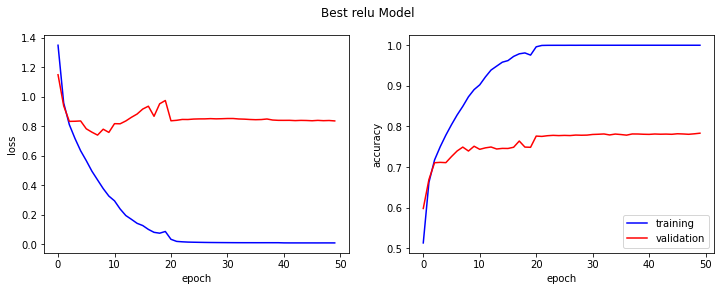

In [9]:
#plot learning curve for loss and accuracy
file_name = "best_relu_model"
epochs = np.arange(50)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Best relu Model")
ax[0].plot(epochs, history['training history'], linestyle='-', color='b', label='training')
ax[0].plot(epochs, history['validation history'], linestyle='-', color='r', label='validation')
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")

ax[1].plot(epochs, history['training accuracy'], linestyle='-', color='b', label='training')
ax[1].plot(epochs, history['validation accuracy'], linestyle='-', color='r', label='validation')
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")

ax[1].legend(loc='lower right')
fig.savefig(file_name+".png", format='png', bbox_inches = 'tight', pad_inches=0.05)